Data path:/Users/holgermaxfloelyng/Desktop/BioMed/MSc_Biomed/SEM_3/project/mlops_project/data
torch.Size([64, 157])
['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'berlin', 'managua', 'vanimo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_

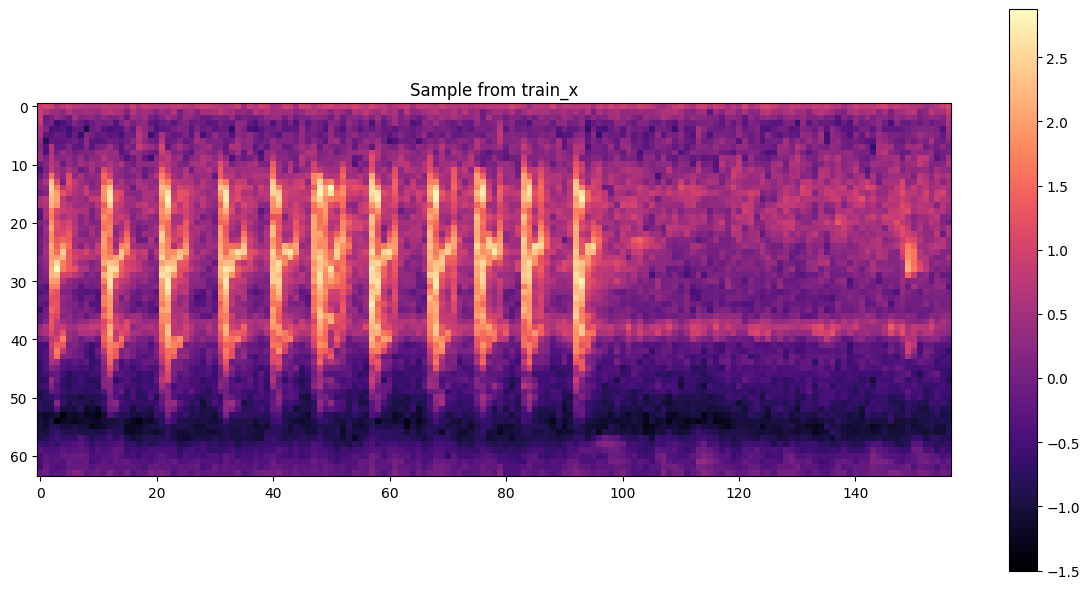

Shape: torch.Size([33378, 1, 64, 157])
Data type: torch.float32
Min: -2.5308468341827393, Max: 4.94235897064209


In [55]:
import torch
import torchaudio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
from call_of_func.train.train_helper import get_device
from call_of_birds_autobird.model import Model

from matplotlib import colormaps
data_root = Path.cwd().parent / "data" 
print(f"Data path:{data_root}")
train_x = torch.load(data_root / "processed" / "train_x.pt")

print(train_x[0, 0].shape)

print(list(colormaps))
plt.figure(figsize=(12, 6))
plt.imshow(train_x[12, 0].numpy(), cmap='magma')
plt.title('Sample from train_x')
plt.colorbar()
plt.tight_layout()
plt.show()

print(f"Shape: {train_x.shape}")
print(f"Data type: {train_x.dtype}")
print(f"Min: {train_x.min()}, Max: {train_x.max()}")

In [56]:
def plot_waveform_and_mel(waveform: torch.Tensor, mel: torch.Tensor, sr: int):
    """
    waveform: [1, N] or [N]
    mel: [n_mels, T]
    """
    # if waveform larger than 1 dim
    if waveform.ndim == 2:
        waveform_1d = waveform.squeeze(0) # [N] 
    else:
        waveform_1d = waveform # [N]

    waveform_1d = waveform_1d.detach().cpu()

    mel_2d = mel.detach().cpu()
    if mel_2d.ndim == 3:
        mel_2d = mel_2d.squeeze(0) # [n_mels, T]
    mel_2d = mel_2d.numpy()

    t = np.arange(waveform_1d.numel()) / sr

    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

    axs[0].plot(t, waveform_1d.numpy())
    axs[0].set_title("Waveform")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")
    axs[0].set_xlim(0, t[-1] if len(t) > 0 else 1)

    axs[1].imshow(mel_2d, aspect="auto", origin="lower", cmap="magma")
    axs[1].set_title("Mel spectrogram (log)")
    axs[1].set_xlabel("Frame")
    axs[1].set_ylabel("Mel bin")

    plt.tight_layout()
    plt.show()


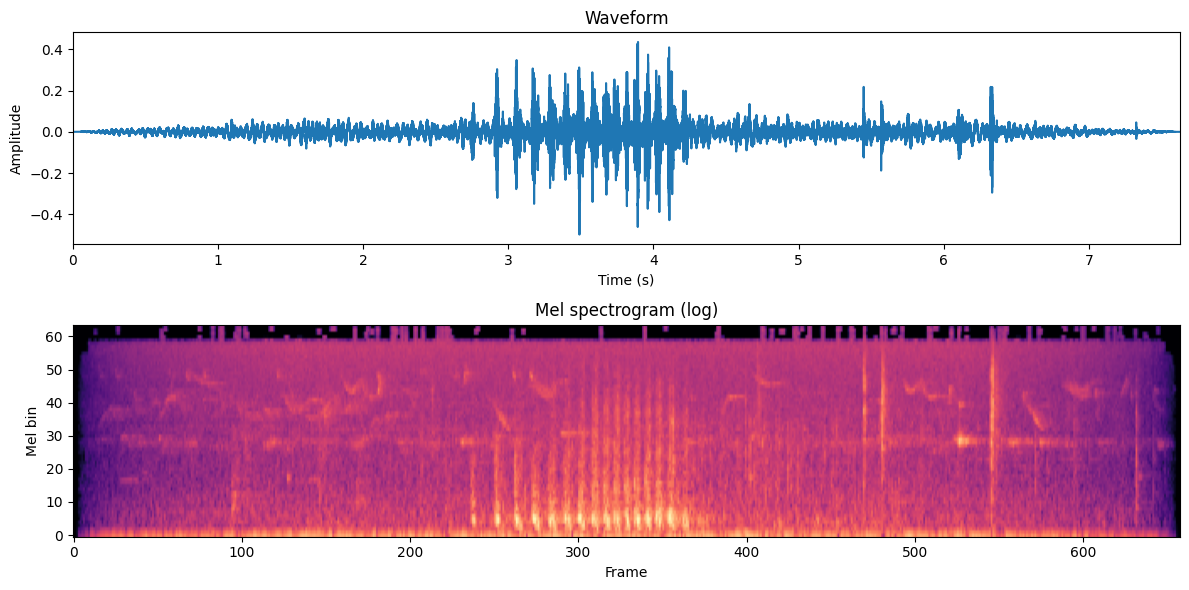

In [57]:

raw_data = data_root / "voice_of_birds" / "Andean_Guan_sound" / "Andean_Guan10.mp3"
waveform, sr = torchaudio.load(raw_data)

# mono
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=1024,
    hop_length=512,
    n_mels=64,
)

mel = mel_transform(waveform)         # [1, 64, time]
mel = torch.log(mel + 1e-6)           # log-compress
mel = mel.squeeze(0)                  # [64, time]

plot_waveform_and_mel(waveform, mel, sr)

In [58]:
def plot_label_distribution(y, title="Label distribution"):
    import matplotlib.pyplot as plt
    import torch

    counts = torch.bincount(y)
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(counts)), counts.numpy())
    plt.xlabel("Class index")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


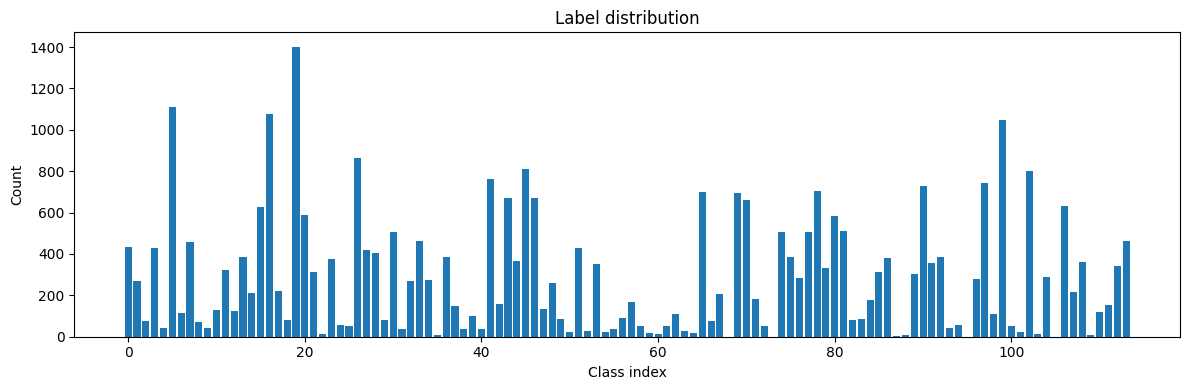

In [59]:
train_y = data_root / "processed" / "train_y.pt"
train_y = torch.load(train_y)
plot_label_distribution(train_y)

In [60]:
def plot_value_histogram(x, title):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 4))
    plt.hist(x.flatten().numpy(), bins=100)
    plt.title(title)
    plt.tight_layout()
    plt.show()


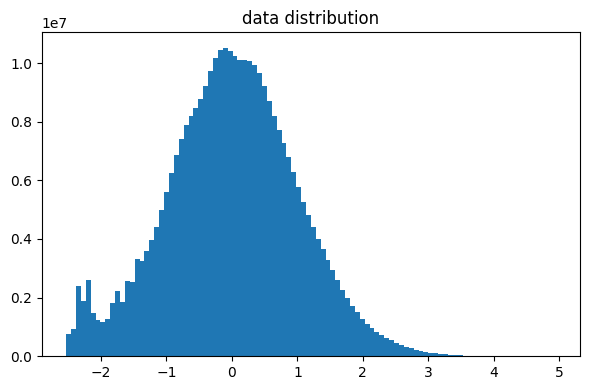

In [61]:
plot_value_histogram(train_x, "data distribution")

In [62]:
def plot_specaugment(original, augmented):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(original, aspect="auto", origin="lower", cmap="magma")
    axs[0].set_title("Original")

    axs[1].imshow(augmented, aspect="auto", origin="lower", cmap="magma")
    axs[1].set_title("After SpecAugment")

    plt.tight_layout()
    plt.show()


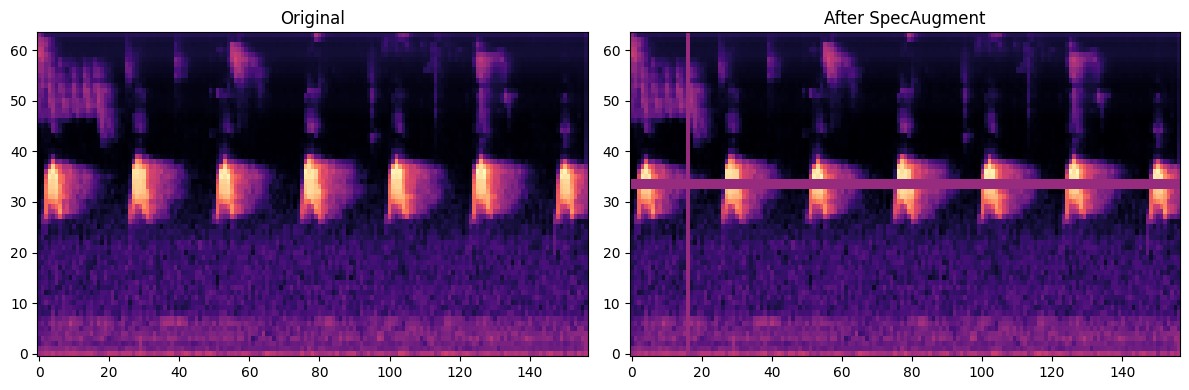

In [63]:
import torchaudio
import torch

ds = TensorDataset(train_x, train_y)
train_loader = DataLoader(ds, batch_size=32, shuffle=True)

x, y = next(iter(train_loader))     # x: [B, 1, n_mels, time]

mel_orig = x[0, 0].cpu()            # [n_mels, time]
mel_aug  = mel_orig.clone()

# IMPORTANT: masking expects torch.Tensor
mel_aug = fq_mask(mel_aug)
mel_aug = time_mask(mel_aug)

plot_specaugment(mel_orig.numpy(), mel_aug.numpy())


In [64]:
def plot_confusion_matrix(cm, class_names=None):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.title("Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [ ]:

device = torch.device("cuda") 

device = get_device()
ds = TensorDataset(train_x, train_y)
val_loader = DataLoader(ds, batch_size=32, shuffle=True)

model = Model(n_classes=len(train_y))

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()



NameError: name 'new_names' is not defined

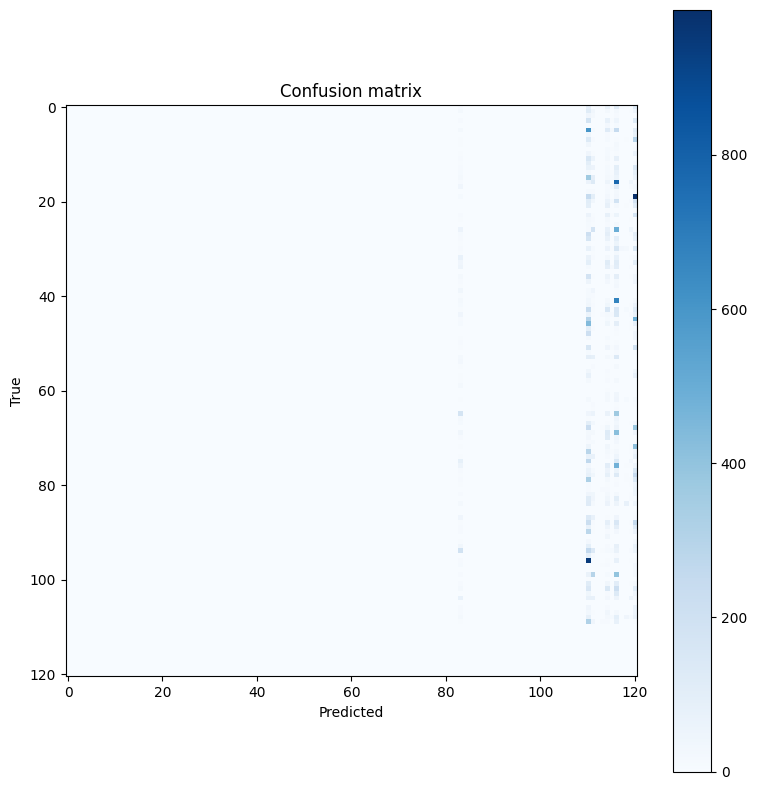

In [66]:
cm = confusion_matrix(all_targets, all_preds)
plot_confusion_matrix(cm)